In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn.neighbors import NearestNeighbors

import math

from cvxopt import solvers, matrix

import time

import itertools

%matplotlib notebook
#plt.ion()

In [2]:
# Hyperparameters
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 100

#random_seed = 1
#torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

In [3]:
def data_func(npoints=10):
    width = 2/9
    first = np.random.uniform(-1 + 1*width, -1 + 2*width, (npoints//4, 1))
    firsty = np.zeros((npoints//4, 2))
    firsty[:, 0] = 1
    second = np.random.uniform(-1 + 3*width, -1 + 4*width, (npoints//4, 1))
    secondy = np.zeros((npoints//4, 2))
    secondy[:, 1] = 1
    third = np.random.uniform(-1 + 5*width, -1 + 6*width, (npoints//4, 1))
    thirdy = np.zeros((npoints//4, 2))
    thirdy[:, 0] = 1
    fourth = np.random.uniform(-1 + 7*width, -1 + 8*width, (npoints//4, 1))
    fourthy = np.zeros((npoints//4, 2))
    fourthy[:, 1] = 1
    
    x = np.vstack((first, second, third, fourth))
    y = np.vstack((firsty, secondy, thirdy, fourthy))
    
    return x, y

<IPython.core.display.Javascript object>


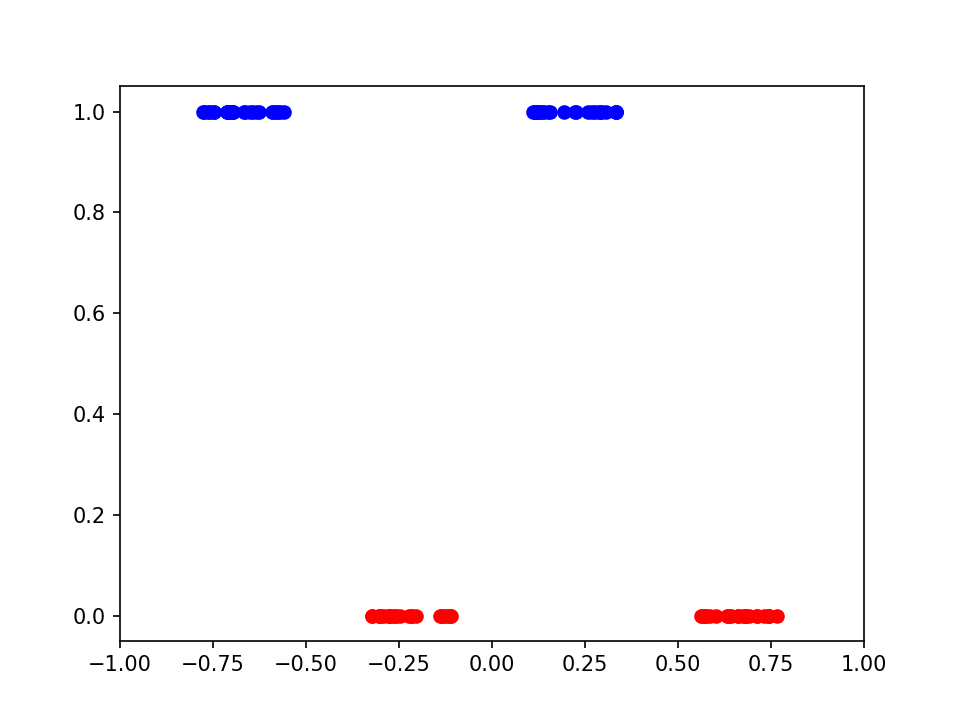

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = data_func(100)
ax.plot(x[y[:, 0] > y[:, 1]], np.ones((x[y[:, 0] > y[:, 1]].shape[0], 1)), 'bo')
ax.plot(x[y[:, 0] < y[:, 1]], np.zeros((x[y[:, 0] < y[:, 1]].shape[0], 1)), 'ro')
ax.set_xlim([-1, 1]);

In [5]:
# Set up the ReLULayer Pytorch module
# Apply affine transformation then rectified linear unit
class ReLULayer(nn.Module):
    # Set up a ReLU layer for ease of use
    def __init__(self, input_dim, output_dim):
        super(ReLULayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) # Just one affine transformation

    def forward(self, x):
        return F.relu(self.linear(x)) # Apply the affine transformation and then the ReLU

In [31]:
# Set up the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_structure, learning_rate=0.001):
        super(NeuralNetwork, self).__init__()
        self.hidden_structure = hidden_structure

        layers = []
        layers.append(ReLULayer(input_dim, hidden_structure[0])) # Setup initial hidden layer

        for i in range(1, len(hidden_structure)):
            layers.append(ReLULayer(hidden_structure[i-1], hidden_structure[i])) # Setup hidden layers

        layers.append(nn.Linear(hidden_structure[-1], output_dim)) # Setup output layer (linear)

        self.layers = nn.ModuleList(layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        self.num_params = sum([np.prod(p.size()) for p in model_parameters])

    def forward(self, x):
        out = x

        for layer in self.layers:
            out = layer(out) # Apply hidden layers

        return out

    def train(self, X_train, y_train, loss_function):
        pred = self(X_train) # Predict from our inputs
        loss = loss_function(pred, y_train) # Calculate the loss
        # Backpropgate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

In [39]:
# Data info
num_inputs = 1
num_outputs = 2
hidden_structure = [20]

# Hyper-parameters 
num_epochs = 5000
learning_rate = 0.001

# Setup for the network
model = NeuralNetwork(num_inputs, num_outputs, hidden_structure, learning_rate=learning_rate)

loss_function = nn.BCEWithLogitsLoss()

<IPython.core.display.Javascript object>


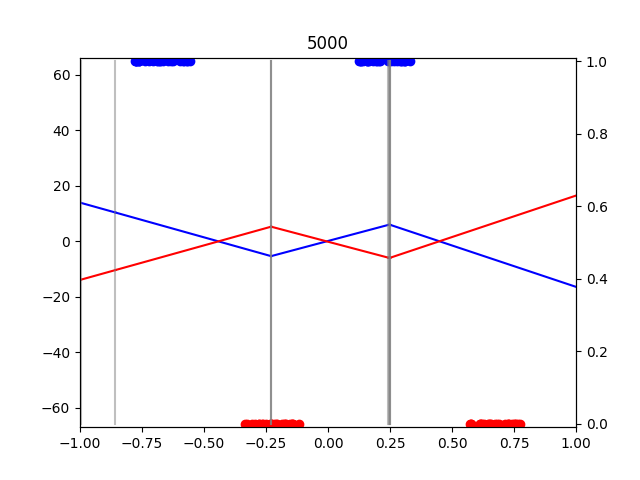

In [40]:
#xTest = np.linspace(-1, 1, 1000).reshape((-1, 1))

xTrain = torch.from_numpy(x).float()
yTrain = torch.from_numpy(y).float()

fig = plt.figure()
ax = fig.add_subplot(111)
axRight = ax.twinx()
for epoch in range(1, num_epochs+1):
    model.train(xTrain, yTrain, loss_function)
    
    if epoch == 1 or epoch % 10 == 0:        
        ax.clear()
        axRight.clear()
        
        params = []
        for param in model.parameters():
            params.append(param.clone().detach().numpy())

        A1 = params[0]
        b1 = params[1]
        
        breaks = np.divide(-b1, A1.reshape(-1))
        
        
        #output = model.forward(torch.from_numpy(xTest).float()).detach().numpy()
        #ax.plot(xTest, output[:, 0], 'b.')
        #ax.plot(xTest, output[:, 1], 'r.')

        axRight.plot(x[y[:, 0] > y[:, 1]], np.ones((x[y[:, 0] > y[:, 1]].shape[0], 1)), 'bo')
        axRight.plot(x[y[:, 0] < y[:, 1]], np.zeros((x[y[:, 0] < y[:, 1]].shape[0], 1)), 'ro')

        ax.set_title(str(epoch))
        ax.set_xlim([-1, 1])
        np.ndarray.sort(breaks)
        for i in range(breaks.shape[0] - 1):
            output = model.forward(torch.from_numpy(np.vstack((breaks[i], breaks[i+1]))).float()).detach().numpy()
            
            ax.plot([breaks[i], breaks[i+1]], [output[0, 0], output[1, 0]], 'b')
            ax.plot([breaks[i], breaks[i+1]], [output[0, 1], output[1, 1]], 'r')
        
        for elem in breaks:
            axRight.plot([elem, elem], [0, 1], c='gray', alpha=0.5)
            
        axRight.set_ylim([-.01, 1.01])
        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        #time.sleep(1)
    

<IPython.core.display.Javascript object>


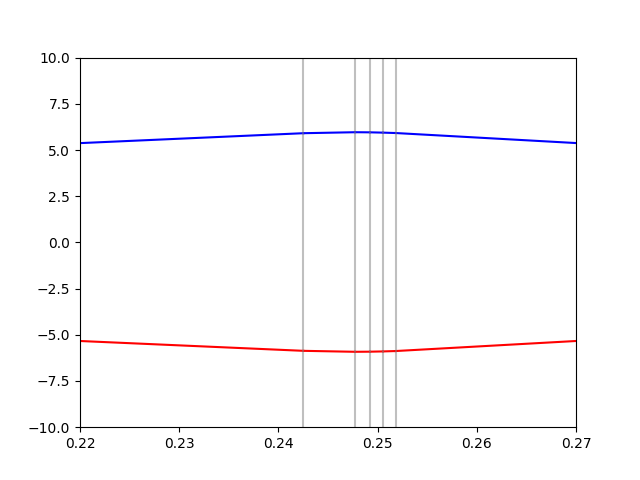

(-10, 10)

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(breaks.shape[0] - 1):
    output = model.forward(torch.from_numpy(np.vstack((breaks[i], breaks[i+1]))).float()).detach().numpy()

    ax.plot([breaks[i], breaks[i+1]], [output[0, 0], output[1, 0]], 'b')
    ax.plot([breaks[i], breaks[i+1]], [output[0, 1], output[1, 1]], 'r')
    
for elem in breaks:
    ax.plot([elem, elem], [-100000, 10000], c='gray', alpha=0.5)
    
ax.set_xlim([0.22, 0.27])
ax.set_ylim([-10, 10])

<IPython.core.display.Javascript object>


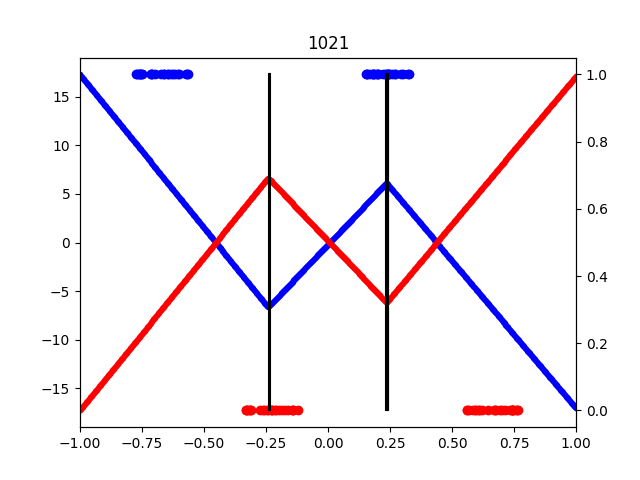

In [141]:
fig = plt.figure()
ax = fig.add_subplot(111)
axRight = ax.twinx()

params = []
for param in model.parameters():
    params.append(param.detach().numpy())

A1 = params[0]
b1 = params[1]

breaks = calcBreaks(A1, b1)


output = model.forward(torch.from_numpy(xTest).float()).detach().numpy()
ax.plot(xTest, output[:, 0], 'b.')
ax.plot(xTest, output[:, 1], 'r.')

axRight.plot(x[y[:, 0] > y[:, 1]], np.ones((x[y[:, 0] > y[:, 1]].shape[0], 1)), 'bo')
axRight.plot(x[y[:, 0] < y[:, 1]], np.zeros((x[y[:, 0] < y[:, 1]].shape[0], 1)), 'ro')

ax.set_title(str(epoch))
ax.set_xlim([-1, 1])

for elem in breaks:
    axRight.plot([elem, elem], [0, 1], 'k')

In [15]:
np.amax(np.array([]), initial=float('-inf'))

-inf

In [97]:
breaks = np.divide(b1, A1.reshape(-1))

In [101]:
print(A1)

[[-0.66654885]
 [-0.43803608]
 [-0.59259033]
 [ 0.21099137]
 [-1.0013082 ]
 [ 1.9412482 ]
 [ 0.24852015]
 [-0.0486676 ]
 [-0.47797894]
 [-0.3547855 ]
 [-0.6890181 ]
 [-0.8832387 ]
 [-0.4678031 ]
 [ 1.8852395 ]
 [ 2.1938057 ]
 [-0.1815962 ]
 [-0.5368024 ]
 [ 0.7743695 ]
 [ 0.5657719 ]
 [ 1.7724547 ]]


In [102]:
print(b1)

[-0.8630791  -0.34140003 -0.9240701   0.5047087   1.0459278  -0.60912305
  0.4650379   0.33074355 -0.5837476  -0.3705339   1.119468   -0.8052907
 -0.47390807 -0.58584136 -0.68387854  0.56463385 -0.685668   -0.72468823
  0.75341964 -0.55688584]
